# STEP 1 - Basic OFDM chain

We will simulate a basic ofdm chain on a AWGN channel

allCarriers:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
pilotCarriers: [ 0  8 16 24 32 40 48 56 63]
dataCarriers:  [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 28 29 30 31 33 34 35 36 37 38 39 41 42 43 44 45 46 47 49 50 51 52 53 54
 55 57 58 59 60 61 62]


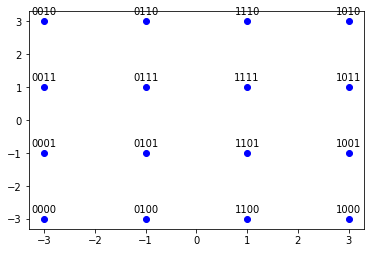

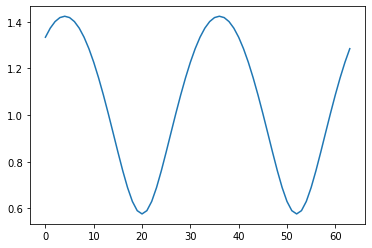

Bits count:  220
First 20 bits:  [1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0]
Mean of bits (should be around 0.5):  0.509090909090909
First 5 bit groups
[[1 0 0 0]
 [0 1 1 0]
 [0 1 0 0]
 [0 1 1 0]
 [1 1 0 0]]
First 5 QAM symbols and bits:
[[1 0 0 0]
 [0 1 1 0]
 [0 1 0 0]
 [0 1 1 0]
 [1 1 0 0]]
[ 3.-3.j -1.+3.j -1.-3.j -1.+3.j  1.-3.j]


In [1]:
proute = 1

#HONTEUX PLAGIAT DE CE SITE/
"""https://dspillustrations.com/pages/posts/misc/python-ofdm-example.html"""

import numpy as np
import matplotlib.pyplot as plt


#######################TRANSMISSION CARACTERISTICS##########################

K = 64 # number of OFDM subcarriers
CP = K//4  # length of the cyclic prefix: 25% of the block
P = 8 # number of pilot carriers per OFDM block
pilotValue = 3+3j # The known value each pilot transmits

allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])

pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)

print ("allCarriers:   %s" % allCarriers)
print ("pilotCarriers: %s" % pilotCarriers)
print ("dataCarriers:  %s" % dataCarriers)
# plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
# plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')


mu = 4 # bits per symbol (i.e. 16QAM)
payloadBits_per_OFDM = len(dataCarriers)*mu  # number of payload bits per OFDM symbol




#######################CONSTELLATION##########################



mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
                
                
plt.show()                   
#######################CHANNEL RESPONSE##########################
                
channelResponse = np.array([1, 0, 0.3+0.3j])  # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K)
plt.plot(allCarriers, abs(H_exact))
plt.show()   
SNRdb = 25  # signal to noise-ratio in dB at the receiver

#######################RANDOM SYMBOLS##########################

bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
print ("Bits count: ", len(bits))
print ("First 20 bits: ", bits[:20])
print ("Mean of bits (should be around 0.5): ", np.mean(bits))
    

#######################SERIAL->PARALLEL##########################
"""
On met par paquet la séquence précédemment créée (paquet de 4 car 1symb = 4 bits
"""
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))
bits_SP = SP(bits)
print ("First 5 bit groups")
print (bits_SP[:5,:])



#######################MAPPING##########################

def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)
print ("First 5 QAM symbols and bits:")
print (bits_SP[:5,:])
print (QAM[:5])